In [1]:
import datetime
import math
import random
import pandas as pd
import tushare as ts
import numpy as np
import scipy.stats as sts
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fmin_slsqp
from scipy.special import gamma
%matplotlib inline

/Users/pro/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#下载数据并保存
def DownloadData(code,start = '2012-12-31',end = datetime.datetime.now().strftime("%Y-%m-%d"),index = False):
    df = ts.get_k_data(code,start = start,end = end,index = index) 
    df.to_csv(code + '.csv')
    print('代码为 ' + code + ' ，' + start + ' 至 ' +end + ' 的历史价格数据已下载。')

#读取数据，提取收盘价、对数收益率
def ReadCsv(code):
    name = code + '.csv'
    df = pd.read_csv(name)
    df.index = df["date"]
    clo = df['close']
    close = np.array(df.close)
    rts = (np.log(clo) - np.log(clo).shift(1).dropna()).dropna()
    return df,close,rts

#计算均值、方差、偏度、峰度、最大值、最小值
def describe(a,maxmin = 0):  
    mean = np.mean(a)
    var = np.var(a)
    skew = sts.skew(a)
    kurt = sts.kurtosis(a)
    Max = np.max(a)
    Min = np.min(a)
    if maxmin == 0:
        des = pd.Series([mean, var, skew, kurt],index = ["mean","variance","skewness","kurtosis"])
    else :
        des = pd.Series([mean, var, Max, Min],index = ["mean","variance","max","min"])
    return des

#画出acf图，并排版（3张）
def drawacf(data1,title1,data2,title2,data3,title3):
    fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(30,5))
    fig = sm.graphics.tsa.plot_acf(data1,lags = 100,ax = ax0,title = title1+' acf', alpha = 0.05,zero= False)
    fig = sm.graphics.tsa.plot_acf(data2,lags = 100,ax = ax1,title = title2+' acf', alpha = 0.05,zero= False)
    fig = sm.graphics.tsa.plot_acf(data3,lags = 100,ax = ax2,title = title3+' acf', alpha = 0.05,zero= False)

#画出直方图，并排版（3张）
def drawhist(data1,title1,data2,title2,data3,title3):
    fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(30,10)) 
    ax0.hist(data1,40)
    ax0.set_title(title1,fontsize = 20)
    ax1.hist(data2,40)
    ax1.set_title(title2,fontsize = 20)
    ax2.hist(data3,40)
    ax2.set_title(title3,fontsize = 20)

#画出QQ图，并排版（3张）
def drawqq(data1,title1,data2,title2,data3,title3):
    fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(30,5))
    fig = sm.qqplot(data1,line='s',ax = ax0)
    ax0.set_title(title1,fontsize = 20)
    fig = sm.qqplot(data2,line='s',ax = ax1) 
    ax1.set_title(title2,fontsize = 20)
    fig = sm.qqplot(data3,line='s',ax = ax2)
    ax2.set_title(title3,fontsize = 20)

#根据公式，求历史波动率，Close-to-Close方法
def CtC(data, N):
    T = np.size(data)
    std_CtC = np.zeros((T-N,1))
    for i in range(0,T-N):
        std_CtC[i] = np.sqrt((1/(N-1))*np.sum((data[i:i+N]-(1/N)*np.sum(data[i:i+N]))**2))
    return std_CtC

#根据公式，求历史波动率，Parkinson方法
def PHV(data,N):
    un = np.log(data.high/data.open)
    dn = np.log(data.low/data.open)
    T = np.size(data.close)
    std_P = np.zeros((T-N,1))
    for i in range(0,T-N):
        std_P[i] = np.sqrt((1/(4*N*np.log(2)))*np.sum((un[i:i+N]-dn[i:i+N])**2))
    return std_P
    
#根据公式，求历史波动率，Garman-Klass方法
def GKHV(data,N):
    un = np.log(data.high/data.open)
    dn = np.log(data.low/data.open)
    cn = np.log(data.close/data.open)
    T = np.size(data.close)
    std_GK = np.zeros((T-N,1))
    for i in range(0,T-N):
        pat1 = (0.511/N)*np.sum((un[i:i+N]-dn[i:i+N])**2)
        pat2 = (0.019/N)*np.sum(cn[i:i+N]*(un[i:i+N]+dn[i:i+N])-2*un[i:i+N]*dn[i:i+N])
        pat3 = (0.383/N)*np.sum(cn[i:i+N]**2)
        std_GK[i] = np.sqrt(pat1-pat2-pat3)
    return std_GK

#根据公式，求历史波动率，Rogers方法
def RHV(data,N):
    un = np.log(data.high/data.open)
    dn = np.log(data.low/data.open)
    cn = np.log(data.close/data.open)
    T = np.size(data.close)
    std_R = np.zeros((T-N,1))
    for i in range(0,T-N):
        std_R[i] = np.sqrt((1/N)*np.sum(un[i:i+N]*(un[i:i+N]-cn[i:i+N])+dn[i:i+N]*(dn[i:i+N]-cn[i:i+N])))
    return std_R

#画出历史波动率
def drawhv(df,rts,name):
    plt.grid()
    plt.plot(CtC(rts,30),linestyle="-",label="CtC")
    plt.plot(PHV(df,30),linestyle="-",label="Parkinson")    
    plt.plot(GKHV(df,30),linestyle="-",label="Garman-Klass")
    plt.plot(RHV(df,30),linestyle="-",label="Rogers")  
    plt.title(name + ' historical volatility',fontsize = 20)
    plt.legend(loc='upper left')

#画出ES、VAR
def drawes(df,name):
    data_VaR = - GKHV(df,30)*norm.ppf(0.01)
    data_ES = GKHV(df,30)*norm.pdf(norm.ppf(0.01))/0.01
    plt.grid()
    plt.plot(data_VaR,linestyle="-", label ="VaR")
    plt.plot(data_ES,linestyle="-", label ="ES")
    plt.title(name + ' VaR vs ES, p = 0.01, type =Garman-Klass',fontsize = 20)
    plt.legend(loc = "upper left")

#极大似然求GARCH（1，1）波动率
def garch_loglikelihood(parameters, rets, out = None):
    alpha = parameters[0]
    beta = parameters[1]
    omega = (1-alpha-beta)*rets.var()
    T =len(rets)
    sigma2 = np.ones(T)*rets.var()
    Rt2 = rets**2
    # Data and Sigma2 are assumed as T by 1 vectors
    for i in range(T-1):
        sigma2[i+1]=alpha*rets[i]**2+beta*sigma2[i] + omega
        
    logliks = 0.5*(np.log(2*np.pi) + np.log(sigma2) + Rt2/sigma2)
    loglik = np.sum(logliks)
    
    if out is None:
        return loglik/100
    else:
        return loglik, logliks, np.copy(sigma2)

def garch_constraint(parameters, rets, out=None):
    alpha = parameters[0]
    beta = parameters[1]
    return np.array([1-alpha-beta])

#画出garch11波动率
def garch_hv(data,name,p = 1):
    rts = np.array(data)
    startingVals = np.array([0.1,0.85]) 
    T=len(rts)
    bounds  =[(0.0,1.0),(0.0,1.0)]
    sigma2 = np.ones(T)*(rts).var()
    finfo = np.finfo(np.float64)
    args = (np.asarray(rts),)
    estimates = fmin_slsqp(garch_loglikelihood, startingVals, f_ieqcons=garch_constraint,bounds=bounds, args =args)   
    analized= 1
    __, _, sigma2final = garch_loglikelihood(estimates,rts,out=True)
    garch_vol = np.sqrt(analized * sigma2final)
    ested_vol = pd.DataFrame(garch_vol,columns=['estimated vols'])
    if p == 1:
        print('Initial Values=',startingVals)
        print('Estimated Values=',estimates)
        ested_vol.plot(grid='on',color = '#CC0066',title = name + ' volatility with GARCH11',figsize =(16,3) )
        plt.legend(loc='upper left')
    else :
        return garch_vol

def Ngarch_loglikelihood(parameters, rets, out = False):
    alpha = parameters[0] 
    beta = parameters[1]
    theta = parameters[2]
    omega = parameters[3]
    Rt2 = rets**2
    T = len(rets)
    sigma2 = np.ones(T)*rets.var()
    for i in range(T-1):
        sigma2[i+1]  = omega + alpha*(rets[i] - theta*np.sqrt(sigma2[i]))**2 + beta*sigma2[i]
    logliks = 0.5*(np.log(2*np.pi) + np.log(sigma2) + Rt2/sigma2)
    loglik = np.sum(logliks)
    if out == False:
        return loglik/10000
    if out == True:
        return loglik,np.copy(sigma2)    

def Ngarch_constraint(parameters, data, out=None):
    alpha = parameters[0]
    beta = parameters[1]
    theta = parameters[2]
    return np.array([1-(alpha*(1+theta**2))-beta])

#画出NGARCH波动率
def Ngarch_hv(data,name,p = 1):
    rts = np.array(data)
    startingVals = np.array([0.07,0.85,0.5,0.000005]) 
    T=len(rts)
    bounds =[(0.0,1.0),(0.0,1.0),(-10.0,10.0),(0.0,1.0)] 
    sigma2 = np.ones(T)*(rts).var()
    args = (np.asarray(rts),)
    estimates = fmin_slsqp(Ngarch_loglikelihood, startingVals,bounds=bounds,f_ieqcons=Ngarch_constraint, args = args)
    analized = 1
    loglik0, sigma2final = Ngarch_loglikelihood(estimates,rts, out=True)
    garch_vol= np.sqrt(analized*sigma2final)
    ested_vol = pd.DataFrame(garch_vol,columns=['estimated vols'])
    if p == 1:
        print('Initial Values=',startingVals)
        print('Estimated Values=',estimates)
        ested_vol.plot(grid='on',color = '#B22222',title=name + ' volatility with NGACH')
        vol = analized*sigma2final
        return vol
    if p == 2:
        return garch_vol
    else:
        return garch_vol,estimates

def component_garch_loglikelihood(parameters ,rets, out = False):
    alpha_sigma = parameters[0] 
    beta_sigma = parameters[1]
    alpha_vega = parameters[2]
    beta_vega = parameters[3]
    sigma_square = parameters[4]
    T = len(rets)
    Rt2 = rets**2
    sigma2 = np.ones(T)*rets.var()
    vega = np.ones(T)*rets.var()
    for i in range(T-1):
        vega[i+1] = sigma_square + alpha_vega*(Rt2[i] - sigma2[i]) + beta_vega*(vega[i] - sigma_square)
        sigma2[i+1] = vega[i+1] + alpha_sigma*(Rt2[i] - vega[i]) + beta_sigma*(sigma2[i] - vega[i])

    logliks = 0.5*(np.log(2*np.pi) + np.log(sigma2) + Rt2/sigma2)
    loglik = np.sum(logliks)
    if out == False:
        return loglik
    if out == True:
        return loglik,sigma2
        
def component_garch_hv(data,name,p = 1):
    rts = np.array(data)
    startingVals = [0.04, 0.92, 0.05, 0.9, rts.var()]
    T=len(rts)
    bounds =[(0,1),(0,1),(0,1),(0,1),(0,1)]
    sigma2 = np.ones(T)*(rts).var()
    finfo = np.finfo(np.float64)
    args = (np.asarray(rts),)
    estimates = fmin_slsqp(component_garch_loglikelihood, startingVals , args =args)
    analized=252
    loglik, sigma2final = component_garch_loglikelihood(estimates, rts, out=True)
    garch_vol = np.sqrt(analized*sigma2final)
    ested_vol = pd.DataFrame(garch_vol,columns=['estimated vols'])
    if p ==1:
        print('Initial Values=',startingVals)
        print('Estimated Values=',estimates)
        ested_vol.plot(grid='on',color = '#B22222',title=name + ' volatility with component_GACH')
        vol = analized*sigma2final
        return vol
    else:
        return garch_vol


#参数法、历史数据法、蒙特卡罗法计算VaR
def VaR(rts,name):
    VaR1 = -norm.ppf(0.01)*np.var(rts) - np.mean(rts)   #参数法
    
    rts_sort = sorted(rts)
    a = math.ceil(0.01 * len(rts))
    VaR2 = rts_sort[a]   #历史法
    
    R = []
    vol,est = Ngarch_hv(rts,name,p = 0)
    sigma = np.sqrt(est[1]*(np.mean(rts)-est[3]*np.mean(vol))**2 + est[2]*np.mean(vol))
    for i in range(10000):
        R.append(sigma * random.normalvariate(0,1))
    VaR3 = np.mean(R)  #蒙特卡罗法
    
    VaR = pd.Series([VaR1, VaR2,VaR3],index = ["参数法VaR","历史法VaR","蒙特卡罗法VaR"])
    return VaR

def Ngarch_t_loglikelihood(parameter,rts,sigma):
    d = parameter[0]
    loglikes =  - np.log(gamma((d+1)/2)) + np.log(gamma(d/2)) + np.log(np.pi)/2 + 0.5*np.log(d-2) + 0.5*(1+d)*np.log(1+(rts/sigma)**2/(d-2))
    loglike =  loglikes.sum()
    return loglike

def RiskM(rts,name):
    initial_value = rts[:251].var()
    T = len(rts) - 251
    sigma2 = np.ones(T+1)*initial_value 
    for i in range(T):
        sigma2[i+1] = 0.94* sigma2[i] + 0.06*rts[i + 250]**2
    return np.sqrt(sigma2)

def FHIST(rts,name):
    Standardized_Return = rts/Ngarch_hv(rts,name,p = 2)
    sigma = Ngarch_hv(rts,name,p = 2)
    T = len(rts) - 251
    FHIST = np.ones(T)
    for i in range(T):
        FHIST[i] = -sigma[ i + 250]*np.percentile(Standardized_Return[i+1:i+ 250],1)
    return FHIST

def HIST(rts,name):
    T = len(rts) - 251
    HIST = np.ones(T)
    for i in range(T):
        HIST[i] = - np.percentile(rts[i+1:i+ 250],1)
    return HIST


def Asymmetric_t_dist(d1,d2,out = None):
    C = gamma((d1+1)*0.5) / (gamma(d1/2)*np.sqrt(np.pi*(d1-2)))
    A = 4*d2*C*(d1-2)/(d1-1)
    B = np.sqrt(1+3*d2**2-A**2)
    m2 = 1+ 3*d2**2
    m3 = 16*C*d2*(1+d2**2)*(d1-2)**2 / ((d1-1)*(d1-3))
    m4 = 3*(d1-2)*(1+10*d2**2+5*d2**4)/(d1-4)
    skew = (m3-3*m2*A +2*A**3)/B**3
    excess_kur = ((m4-4*A*m3+6*A**2*m2-3*A**4)/B**4) - 3
    pdf=[
    B*C*(1+(B*x+A)**2/((1-d2)**2*(d1-2)))**(-0.5*(1+d1)) if x < -(A/B) else B*C*(1+(B*x+A)**2/((1+d2)**2*(d1-2)))**(-0.5*(1+d1)) for x in  np.linspace(-4,4,1000)
]
    if out == None:
        return pdf
    if out == "skew":
        return skew
    if out =="e_kur":
        return excess_kur

def DCC_loglikelihood(parameter,z1,z2,out = None):
    lamda = parameter[0]
    df = pd.concat([z1,z2],axis = 1)
    df.columns = ["z1","z2"]
    df = df.dropna(axis=0 ,how ="any")
    T = len(df)
    q11 = np.ones(T) 
    q12 = np.ones(T)*(df.z1 * df.z2).sum()/T
    q22 = np.ones(T)
    for i in range(T-1):
        q11[i+1] = (1 - lamda)*(z1**2)[i] + lamda*q11[i]
        q22[i+1] = (1 - lamda)*(z2**2)[i] + lamda*q22[i]
        q12[i+1] = (1 - lamda)*z1[i]*z2[i] + lamda*q12[i]
    q11 = pd.Series(q11, index = df.index)
    q22 = pd.Series(q22, index = df.index)
    rol12 = q12/np.sqrt(q11*q22)
    DCC_loglikelihoods = (np.log(1 - rol12**2) + ((z1**2 + z2**2 - 2*rol12*z1*z2)/(1-rol12**2)))*0.5
    DCC_loglike =  DCC_loglikelihoods.sum()
    if out == None:
        return DCC_loglike
    else:
        return DCC_loglikelihood,rol12

def GARCH_DCC_loglikelihood(parameter,z1,z2,out = None):
    alpha = parameter[0]
    beta = parameter[1]
    df = pd.concat([z1,z2],axis = 1)
    df.columns = ["z1","z2"]
    df = df.dropna(axis=0 ,how ="any")
    T = len(df)
    q11 = np.ones(T) 
    q12 = np.ones(T)*(df.z1 * df.z2).sum()/T
    initialrol12 = (df.z1 * df.z2).sum()/T
    q22 = np.ones(T)
    for i in range(T-1):
        q11[i+1] = 1+ alpha*((z1**2)[i]-1) + beta *(q11[i]-1)
        q12[i+1] = initialrol12 + alpha*(z1[i]*z2[i]- initialrol12) + beta*(q12[i] - initialrol12)
        q22[i+1] = 1+ alpha*((z2**2)[i]-1) + beta *(q22[i]-1)
    q11 = pd.Series(q11, index = df.index)
    q22 = pd.Series(q22, index = df.index)
    rol12 = q12/np.sqrt(q11*q22)
    DCC_loglikelihoods = (np.log(1 - rol12**2) + ((z1**2 + z2**2 - 2*rol12*z1*z2)/(1-rol12**2)))*0.5
    DCC_loglike =  DCC_loglikelihoods.sum()
    if out == None:
        return DCC_loglike
    else:
        return DCC_loglikelihood,rol12

def GARCH_DCC_constraint(parameter,z1,z2,out= None):
    alpha = parameter[0]
    beta = parameter[1]
    return np.array([1 - alpha - beta])

def DCC_Monte(rts1,rts2,estimats,x):
    shock1 = np.random.randn(10000)
    shock2 = np.random.randn(10000)
    alpha = estimats[0]
    beta = estimats[1]
    df = pd.concat([rts1,rts2],axis =1)
    unconditional_corr = df.corr().iloc[0,1]
    q11 = shock1**2*alpha + beta + (1-alpha-beta)
    q22 = shock2**2*alpha + beta + (1-alpha-beta)
    q12 = (1-alpha-beta)*unconditional_corr + beta*x + alpha*shock1*shock2
    rol_0 = np.average(q12/np.sqrt(q11*q22))
    rol = []
    rol.append(rol_0)
    for i in range(20):
        np.random.seed(i)
        shock1 = np.random.randn(10000)
        shock2 = np.random.randn(10000)
        q11 = shock1**2*alpha + beta*q11 + (1-alpha-beta)
        q22 = shock2**2*alpha + beta*q22 + (1-alpha-beta)
        q12 = (1-alpha-beta)*unconditional_corr + beta*q12 + alpha*shock1*shock2
        rol12 = q12/np.sqrt(q11*q22)
        rol.append(np.average(rol12))
        i +=1
    return pd.Series(rol,name=str(x))

In [3]:
def Q1(code1,code2,code3):  
    DownloadData(code1)
    DownloadData(code2)
    DownloadData(code3,index = True)
       
def Q2(df1,data1,name1,df2,data2,name2,df3,data3,name3):
    des_closeprice = pd.concat([describe(data1,maxmin = 0),describe(data2,maxmin = 0),describe(data3,maxmin = 0)],axis = 1)
    des_closeprice.columns = [name1,name2,name3]
    print(des_closeprice)
    print('==========================')
    df_price = pd.concat([df1['close'],df2['close'],df3['close']],axis = 1)
    df_price.columns = [name1,name2,name3] 
    print(df_price.corr())
    print('==========================')
    drawacf(data1,name1,data2,name2,data3,name3)
    drawhist(data1,name1,data2,name2,data3,name3)
    drawqq(data1,name1,data2,name2,data3,name3)
    
def Q3(rts1,name1,rts2,name2,rts3,name3):
    des_return = pd.concat([describe(rts1,maxmin = 0),describe(rts2,maxmin = 0),describe(rts3,maxmin = 0)],axis = 1)
    des_return.columns = [name1+'rts',name2+'rts',name3+'rts']
    print(des_return)
    print('==========================')
    df_rtn = pd.concat([rts1,rts2,rts3],axis = 1)
    df_rtn.columns = ['rts '+name1,'rts '+name2,'rts '+name3]
    print(df_rtn.corr())
    print('==========================')
    drawacf(rts1,'rts '+name1,rts2,'rts '+name2,rts3,'rts '+name3)
    drawhist(rts1,'rts '+name1,rts2,'rts '+name2,rts3,'rts '+name3)
    drawqq(rts1,'rts '+name1,rts2,'rts '+name2,rts3,'rts '+name3)
    
def Q4(df1,rts1,name1,df2,rts2,name2,df3,rts3,name3):
    plt.figure(figsize=(17,10))
    plt.subplot(311)
    drawhv(df1,rts1,name1)
    plt.subplot(312)
    drawhv(df2,rts2,name2)
    plt.subplot(313)
    drawhv(df3,rts3,name3)
    

def Q5(df1,name1,df2,name2,df3,name3):
    plt.figure(figsize=(17,10))
    plt.subplot(311)
    drawes(df1,name1)
    plt.subplot(312)
    drawes(df2,name2)
    plt.subplot(313)
    drawes(df3,name3)

def Q6_1(rts1,name1,rts2,name2,rts3,name3):   
    garch_hv(rts1,name1,p = 1)
    print('==========================')
    garch_hv(rts2,name2,p = 1)
    print('==========================')
    garch_hv(rts3,name3,p = 1)
    
def Q6_2(rts1,name1,rts2,name2,rts3,name3):
    vol1 = Ngarch_hv(rts1,name1,p = 1)
    print('==========================')
    vol2 = Ngarch_hv(rts2,name2,p = 1)
    print('==========================')
    vol3 = Ngarch_hv(rts3,name3,p = 1)
    drawacf(rts1**2,name1+' R^2',rts2**2,name2+' R^2',rts3**2,name3+' R^2')
    drawacf((rts1**2/vol1),name1+' R^2/sigma^2',(rts2**2/vol2),name2+' R^2/sigma^2',(rts3**2/vol3),name3+' R^2/sigma^2')

def Q6_3(rts1,name1,rts2,name2,rts3,name3):
    vol1 = component_garch_hv(rts1,name1,p = 1)
    print('==========================')
    vol2 = component_garch_hv(rts2,name2,p = 1)
    print('==========================')
    vol3 = component_garch_hv(rts3,name3,p = 1)
    
def Q7(df1,rts1,name1,df2,rts2,name2,df3,rts3,name3):
    for i,j,n in ([df1,rts1,name1],[df2,rts2,name2],[df3,rts3,name3]):
        des_hv = pd.concat([describe(CtC(j,30),maxmin = 1),describe(PHV(i,30),maxmin = 1),describe(GKHV(i,30),maxmin = 1),describe(RHV(i,30),maxmin = 1),describe(garch_hv(j,n,p = 0),maxmin = 1),describe(Ngarch_hv(j,n,p = 2),maxmin = 1)],axis = 1)
        des_hv.columns = ['CtC','Parkinson','Garman-Klass','Rogers','GARCH11','NGARCH']
        print(n + '波动率的统计分析')
        print(des_hv)    
        print('\n\n==========================')

def Q8(data1,name1,data2,name2,data3,name3):
    var = pd.concat([VaR(data1,name1),VaR(data2,name2),VaR(data3,name3)],axis = 1)
    var.columns = [name1,name2,name3]
    print(var)        

def Q9_1(rts1,name1,rts2,name2,rts3,name3):
    nomalized_return1 = rts1/rts1.var()
    nomalized_return2 = rts2/rts2.var()
    nomalized_return3 = rts3/rts3.var()
    drawqq(nomalized_return1,"normalized_return_"+name1,nomalized_return2,"normalized_return_"+name2,nomalized_return3,"normalized_return_"+name3)

def Q9_2_3(rts1,name1,rts2,name2,rts3,name3):
    Ngarch_vol1 = Ngarch_hv(rts1,name1,p = 2)
    Ngarch_vol2 = Ngarch_hv(rts2,name2,p = 2)
    Ngarch_vol3 = Ngarch_hv(rts3,name3,p = 2)
    normalized_rturn1 = rts1/Ngarch_vol1
    normalized_rturn2 = rts2/Ngarch_vol2
    normalized_rturn3 = rts3/Ngarch_vol3
    drawqq(normalized_rturn1,"normalized_return_"+name1,normalized_rturn2,"normalized_return_"+name2,normalized_rturn3,"normalized_return_"+name3)

def Q9_4(rts1,name1,rts2,name2,rts3,name3):
    sigma1 = Ngarch_hv(rts1,name1,p = 1)
    args1 = (rts1, sigma1)
    sigma2 = Ngarch_hv(rts2,name2,p = 1)
    args2 = (rts2, sigma2)
    sigma3 = Ngarch_hv(rts3,name3,p = 1)
    args3 = (rts3, sigma3)
    startingVals = np.array([float(10.0)])
    bounds1 = [(5.0,1000.0)]
    bounds2 = [(5.1,1000.0)]
    bounds3 = [(5.6,1000.0)]
    estimats1 = fmin_slsqp(Ngarch_t_loglikelihood,startingVals,bounds= bounds1,args = args1)
    estimats2 = fmin_slsqp(Ngarch_t_loglikelihood,startingVals,bounds= bounds2,args = args2)
    estimats3 = fmin_slsqp(Ngarch_t_loglikelihood,startingVals,bounds= bounds3,args = args3)
    for x in [estimats1,estimats2,estimats3]:
        sm.qqplot(z, sts.t, distargs=(x,), line='45')
        plt.title("T Q-Q plot")
        plt.show()
    
def Q9_7(rts1,name1,rts2,name2,rts3,name3):
    for i, j, in ([rts1,name1],[rts2,name2],[rts3,name3]):
        Risk_M = pd.Series(RiskM(i,j)[1:])
        Ngarch_t = pd.Series(Ngarch_hv(i,j,p = 2)[251:])
        fhist = pd.Series(FHIST(i,j))
        hist = pd.Series(HIST(i,j))
        df = pd.concat([Risk_M,Ngarch_t,fhist,hist],axis = 1)
        df.columns = ['Risk_M','Narch_t','FHIST','HIST']
        df.plot(figsize= (12,6))

def Q_9_8():
    pdf_rskew = Asymmetric_t_dist(8,0.4) 
    pdf_lskew = Asymmetric_t_dist(8,-0.4)
    x = np.linspace(-4,4,1000)
    plt.plot(x,pdf_rskew,label = "d1 = 8,d2 = 0.4")
    plt.plot(x,pdf_lskew,label = "d1 = 8,d2 = -0.4")
    plt.legend()
    plt.grid()
    plt.title("The asymmetric t distribution")
    
def Q9_9_1():
    skew_5 = [ Asymmetric_t_dist(d1=5, d2 = x, out="skew") for x in np.linspace(-0.9,0.9,20)]
    skew_10 = [ Asymmetric_t_dist(d1=10, d2 = x, out="skew") for x in np.linspace(-0.9,0.9,20)]
    plt.plot(np.linspace(-0.9,0.9,20),skew_5, label = "d1= 5")
    plt.plot(np.linspace(-0.9,0.9,20),skew_10, label = "d1= 10")
    plt.legend()
    plt.grid()
    plt.title("skewness as a function of d2")

def Q9_9_2():
    ekur_05 = [ Asymmetric_t_dist(d1=x, d2 = 0.5, out="e_kur") for x in np.linspace(4.5,14,20)]
    ekur_0 = [ Asymmetric_t_dist(d1=x, d2 = 0, out="e_kur") for x in np.linspace(4.5,14,20)]
    plt.plot(np.linspace(4.5,14,20),ekur_05, label = "d2= 0.5")
    plt.plot(np.linspace(4.5,14,20),ekur_0, label = "d2= 0")
    plt.legend()
    plt.grid()
    plt.title("Excess kurtosis as a function of d1")

def Q10(rts1,vol1,name1,rts2,vol2,name2):
    args = (rts1,rts2)
    bounds =[(0.0,0.9999)]
    startingVals = np.array([0.94])
    estimats = fmin_slsqp(DCC_loglikelihood,startingVals , args = args, bounds= bounds)
    _,rol_rts1_rts2 = DCC_loglikelihood(np.array([.94]),rts1,rts2, out = True)
    df = pd.concat([vol1,vol2,rol_rts1_rts2],axis=1)
    df = df.dropna(axis=0 ,how="any")
    df.columns = ["pfyh_vol","szzs_vol","rol"]
    df["beta"] = df.rol*df.pfyh_vol/df.szzs_vol
    
    title1 = "Dynamic Conditional Correlation of " + name1 + " and " + name2
    title2 = "Dynamic beta of "+ name1 +" and "+ name2
    rol_rts1_rts2.plot(title = title1,figsize = (12,8),label="corr")
    df.beta.plot(title = title2,figsize=(12,8))
    plt.legend()

def Q11():
    data={
        "0.5":DCC_Monte(standardized_rertun1,standardized_rertun3,estimats,x = 0.5),
        "0.3":DCC_Monte(standardized_rertun1,standardized_rertun3,estimats,x = 0.3),
        "- 0.1":DCC_Monte(standardized_rertun1,standardized_rertun3,estimats,x = - 0.1),              
        "- 0.4":DCC_Monte(standardized_rertun1,standardized_rertun3,estimats,x =- 0.4)                          
                        }
    df = pd.DataFrame(data)
    df.plot()

In [4]:
code1 = input('请输入第一个股票代码：   ')
name1 = input('第一个股票名称为：   ')
code2 = input('请输入第二个股票代码：   ')
name2 = input('第二个股票名称为：   ')
code3 = input('请输入指数代码：   ')
name3 = input('指数名称为：   ')

请输入第一个股票代码：   600000
第一个股票名称为：   pfyh
请输入第二个股票代码：   600099
第二个股票名称为：   lhgf
请输入指数代码：   000001
指数名称为：   szzs


In [10]:
Q1(code1,code2,code3)

代码为 600000 ，2012-12-31 至 2018-03-04 的历史价格数据已下载。
代码为 600099 ，2012-12-31 至 2018-03-04 的历史价格数据已下载。
代码为 000001 ，2012-12-31 至 2018-03-04 的历史价格数据已下载。


In [5]:
df1,data1,rts1 = ReadCsv(code1)
df2,data2,rts2 = ReadCsv(code2)
df3,data3,rts3 = ReadCsv(code3)

              pfyh       lhgf           szzs
mean      9.564407   9.393594    2898.936069
variance  9.403684  12.630796  424859.928343
skewness -0.305967   0.458622       0.490159
kurtosis -1.661742  -0.495984       0.214453
          pfyh      lhgf      szzs
pfyh  1.000000  0.842477  0.816682
lhgf  0.842477  1.000000  0.789459
szzs  0.816682  0.789459  1.000000


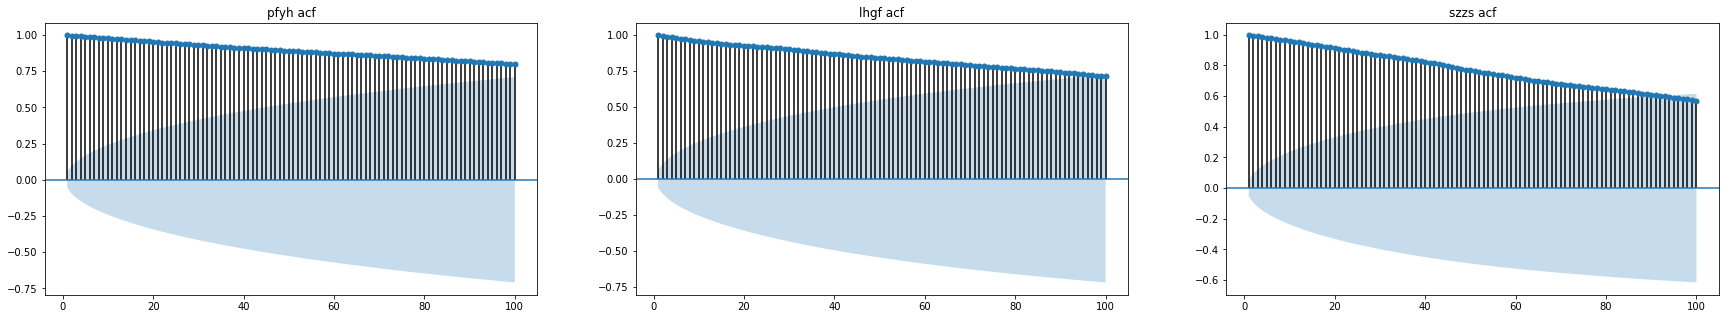

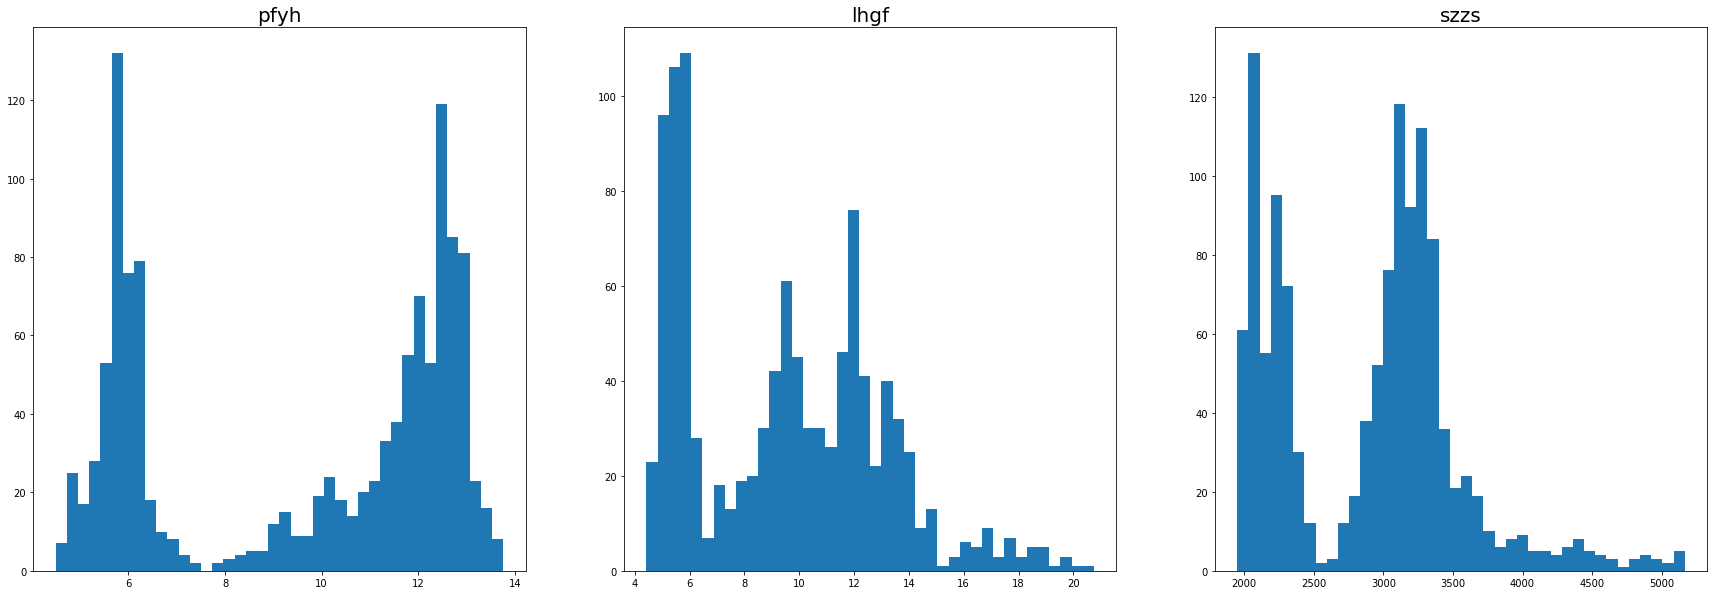

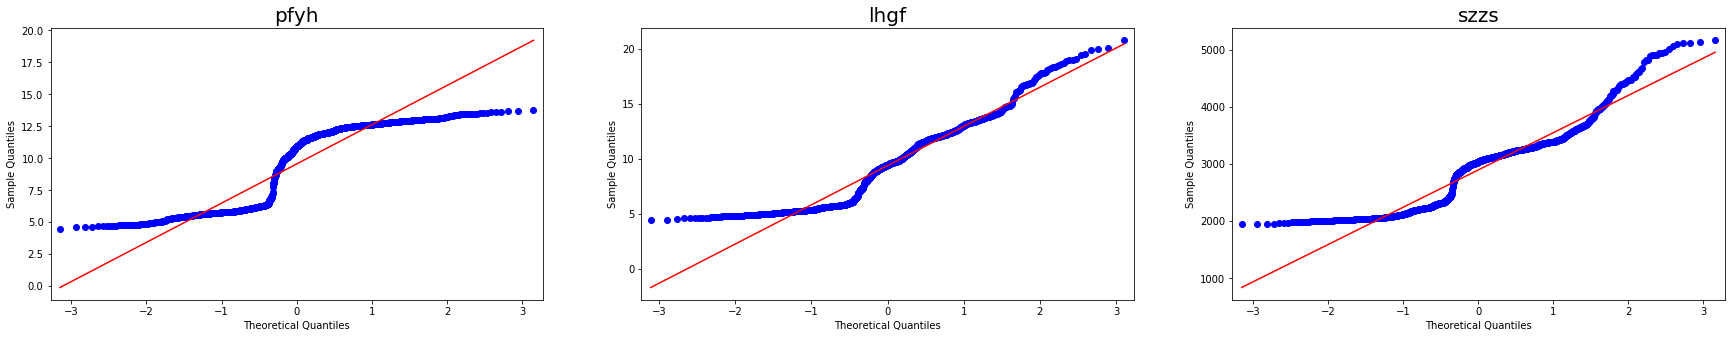

In [11]:
Q2(df1,data1,name1,df2,data2,name2,df3,data3,name3)

           pfyhrts   lhgfrts   szzsrts
mean      0.000650  0.000322  0.000288
variance  0.000391  0.000677  0.000220
skewness  0.161171 -0.487577 -1.254481
kurtosis  5.678958  3.296569  7.324223
          rts pfyh  rts lhgf  rts szzs
rts pfyh  1.000000  0.121286  0.643670
rts lhgf  0.121286  1.000000  0.499832
rts szzs  0.643670  0.499832  1.000000


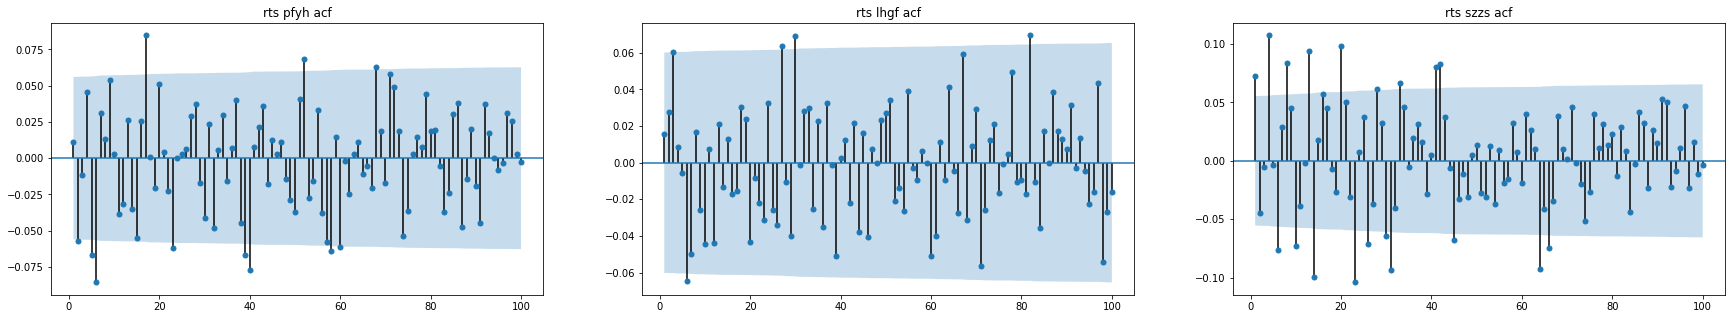

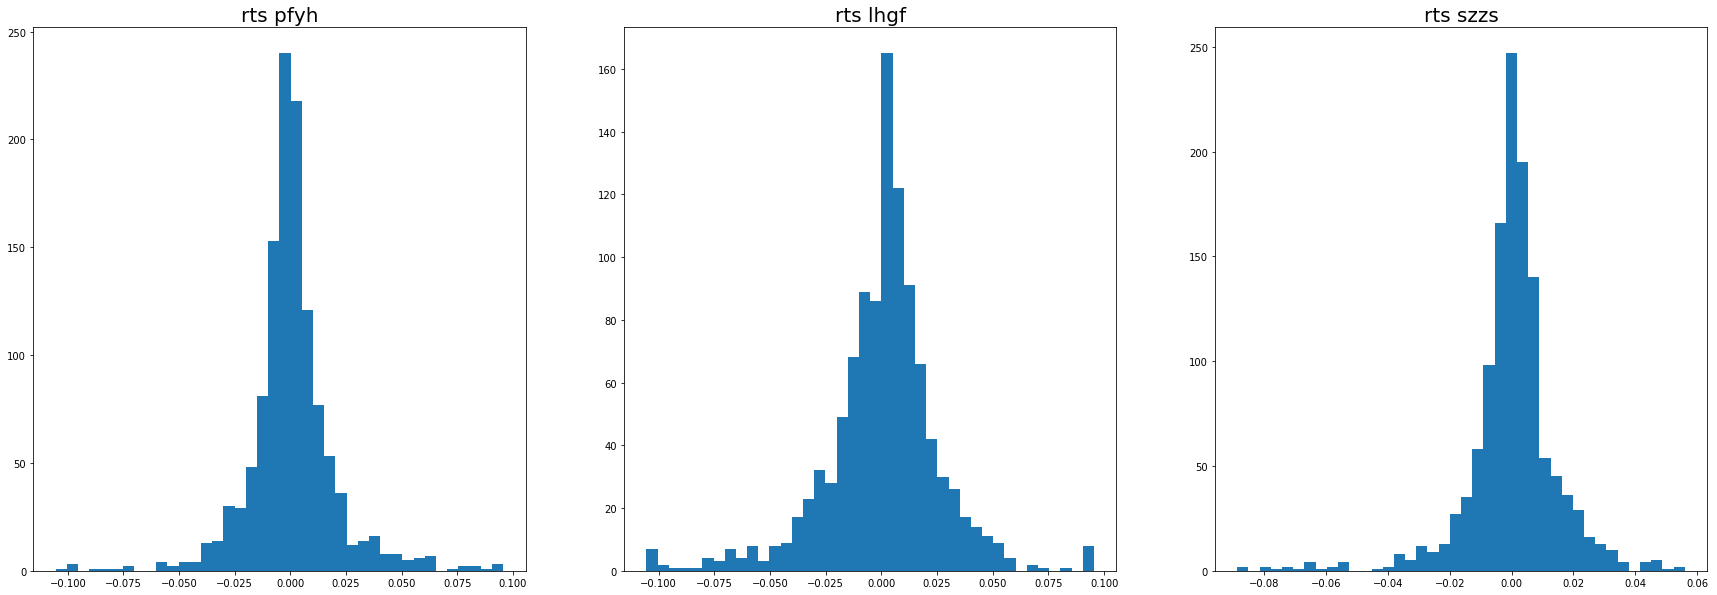

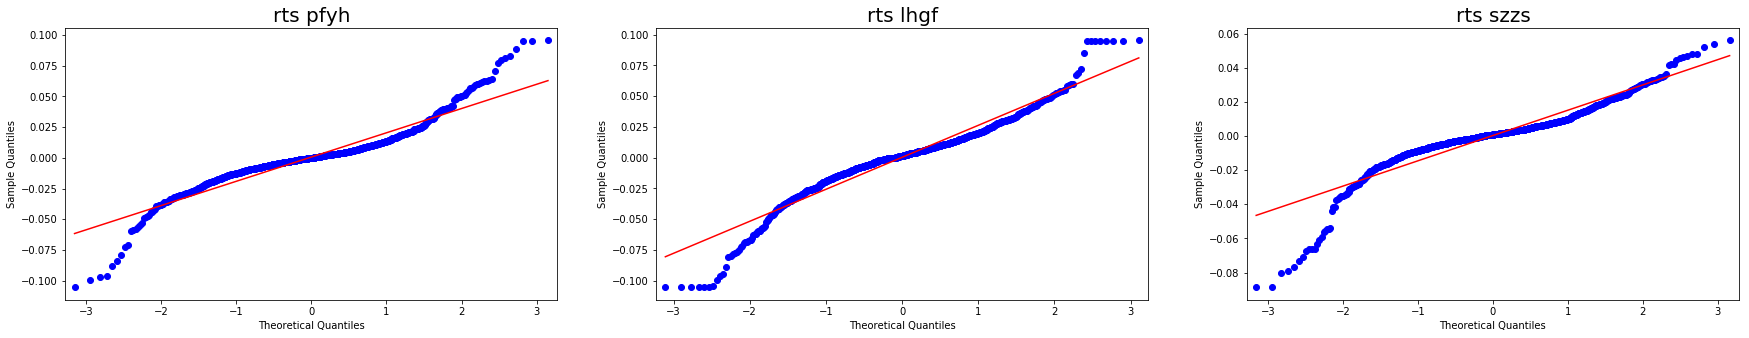

In [12]:
Q3(rts1,name1,rts2,name2,rts3,name3)

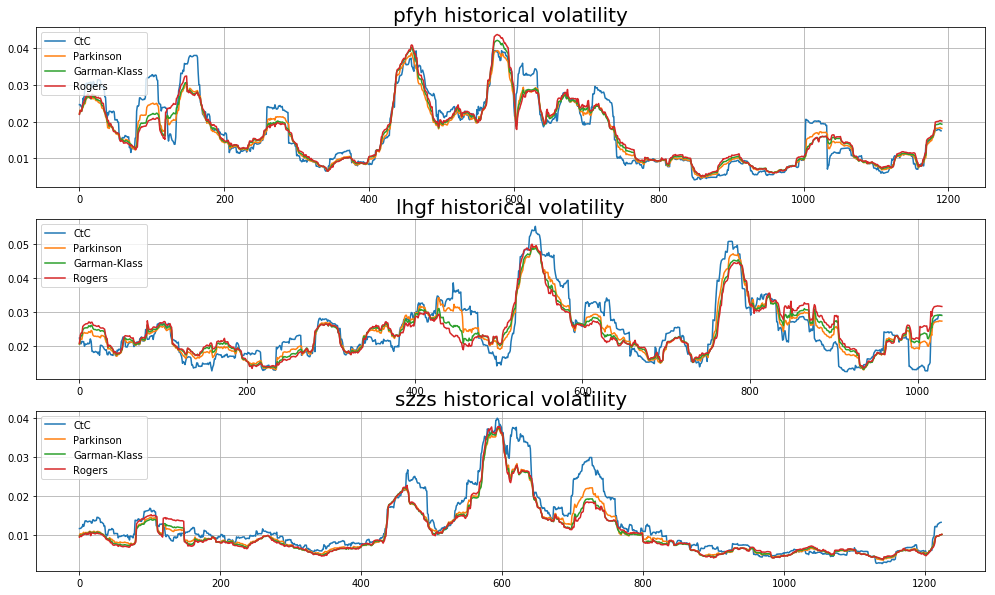

In [19]:
Q4(df1,rts1,name1,df2,rts2,name2,df3,rts3,name3)

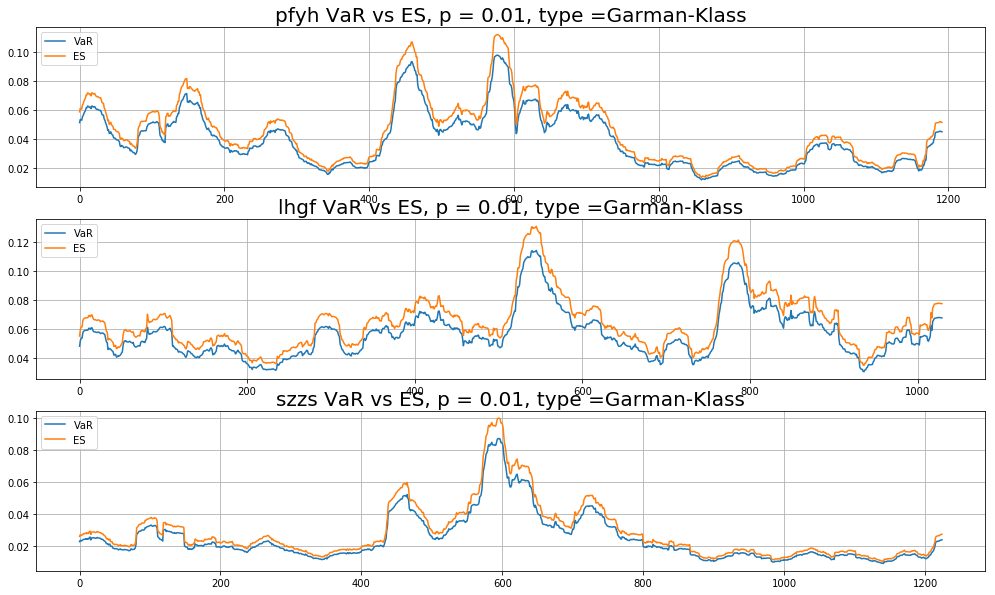

In [20]:
Q5(df1,name1,df2,name2,df3,name3)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -33.019139909572665
            Iterations: 11
            Function evaluations: 50
            Gradient evaluations: 11
Initial Values= [ 0.1   0.85]
Estimated Values= [ 0.14663673  0.84005315]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -24.237556241857543
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 8
Initial Values= [ 0.1   0.85]
Estimated Values= [ 0.07351601  0.87941738]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.43604151531505
            Iterations: 10
            Function evaluations: 43
            Gradient evaluations: 10
Initial Values= [ 0.1   0.85]
Estimated Values= [ 0.06207892  0.93489005]


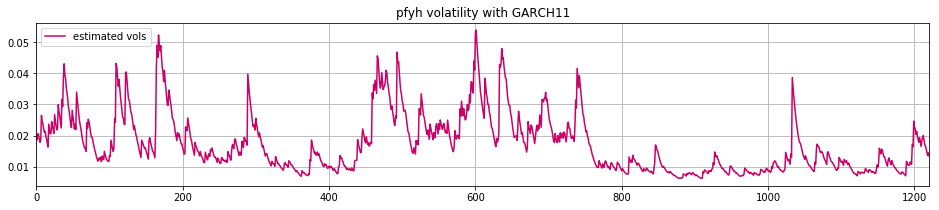

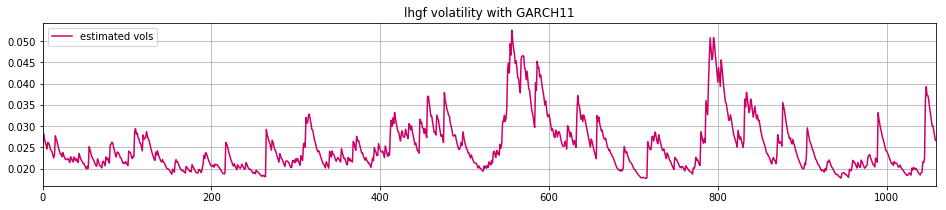

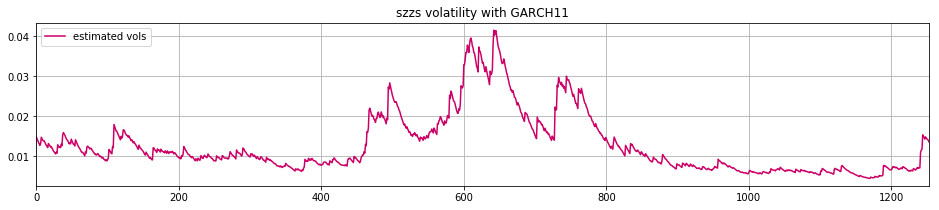

In [39]:
Q6_1(rts1,name1,rts2,name2,rts3,name3)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.33088561748064876
            Iterations: 27
            Function evaluations: 180
            Gradient evaluations: 27
Initial Values= [  7.00000000e-02   8.50000000e-01   5.00000000e-01   5.00000000e-06]
Estimated Values= [  1.70764761e-01   8.23517608e-01  -1.82985297e-01   5.46109237e-06]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2424458586509982
            Iterations: 40
            Function evaluations: 264
            Gradient evaluations: 40
Initial Values= [  7.00000000e-02   8.50000000e-01   5.00000000e-01   5.00000000e-06]
Estimated Values= [  7.07788826e-02   8.79924759e-01  -1.72532993e-01   3.06959947e-05]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.38439939954021163
            Iterations: 47
            Function evaluations: 320
            Gradient evaluations: 47
Initial Val

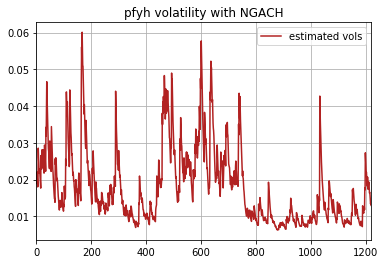

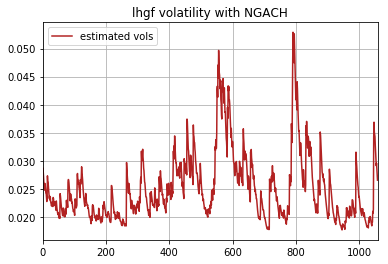

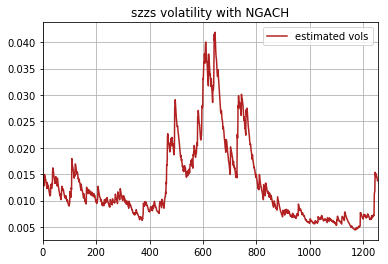

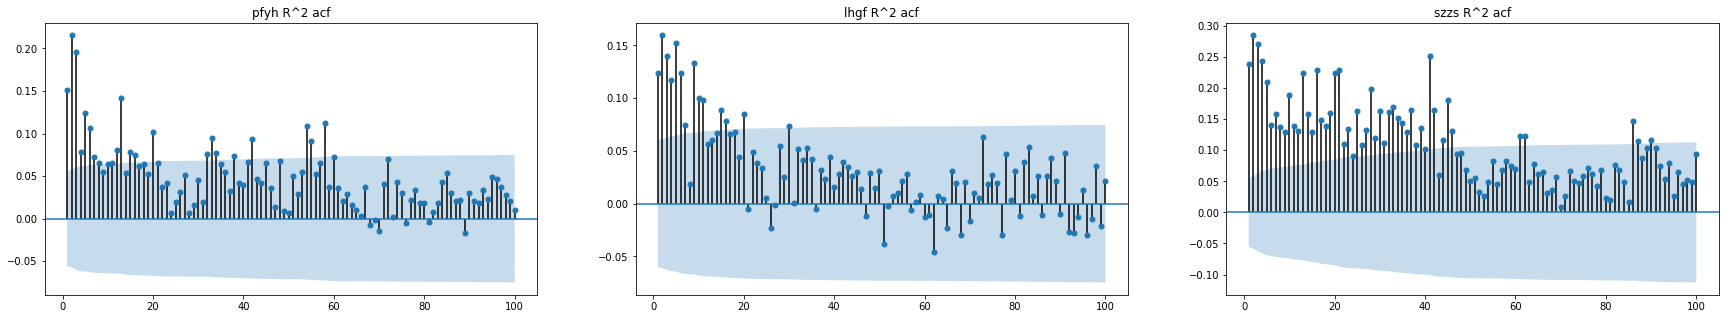

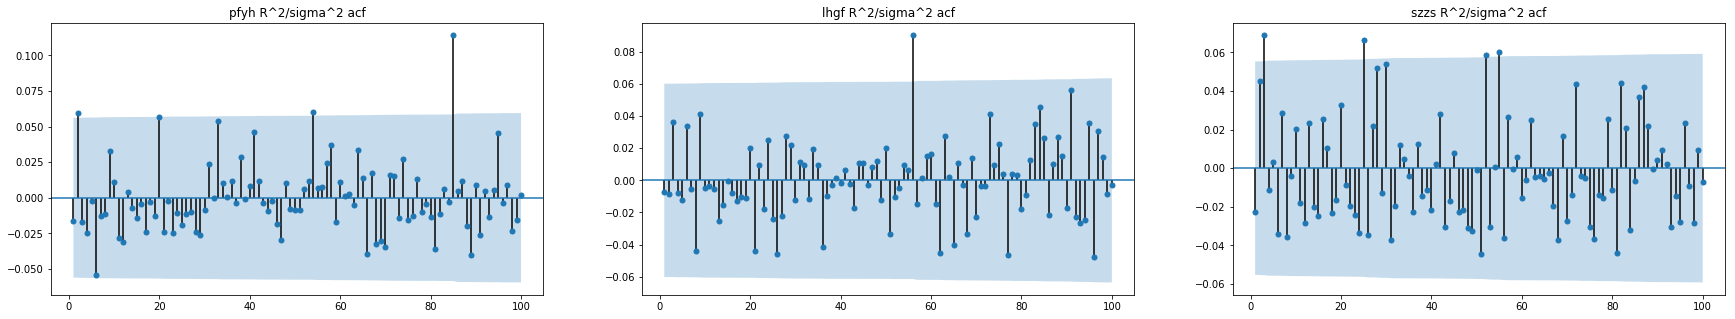

In [40]:
Q6_2(rts1,name1,rts2,name2,rts3,name3)

C:\Users\cx\Anaconda3\lib\site-packages\ipykernel_launcher.py:226: RuntimeWarning: overflow encountered in double_scalars
C:\Users\cx\Anaconda3\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: overflow encountered in double_scalars
C:\Users\cx\Anaconda3\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\cx\Anaconda3\lib\site-packages\ipykernel_launcher.py:229: RuntimeWarning: invalid value encountered in log
C:\Users\cx\Anaconda3\lib\site-packages\ipykernel_launcher.py:226: RuntimeWarning: invalid value encountered in double_scalars


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3318.9579366570083
            Iterations: 30
            Function evaluations: 239
            Gradient evaluations: 30
Initial Values= [0.04, 0.92, 0.05, 0.9, 0.00039080308560698261]
Estimated Values= [ 0.09253148  0.90669908  0.16608303  0.89417629  0.00251221]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2424.5828903693987
            Iterations: 11
            Function evaluations: 101
            Gradient evaluations: 11
Initial Values= [0.04, 0.92, 0.05, 0.9, 0.00067696528495174218]
Estimated Values= [  3.15984508e-02   9.44065214e-01   4.94393279e-02   8.77129236e-01
   6.48943571e-04]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3846.1855280568825
            Iterations: 24
            Function evaluations: 210
            Gradient evaluations: 24
Initial Values= [0.04, 0.92, 0.05, 0.9, 0.00021

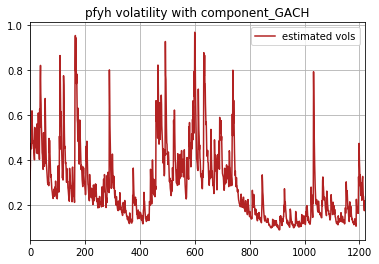

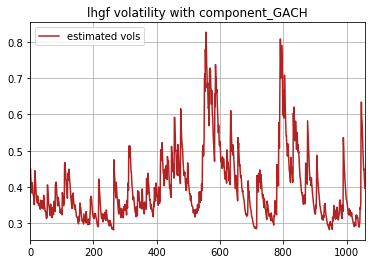

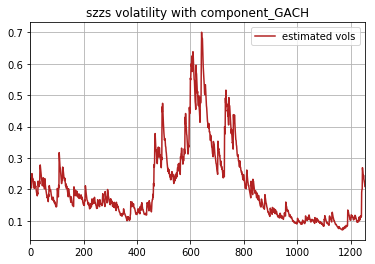

In [41]:
Q6_3(rts1,name1,rts2,name2,rts3,name3)

In [44]:
Q7(df1,rts1,name1,df2,rts2,name2,df3,rts3,name3)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -33.019139909572665
            Iterations: 11
            Function evaluations: 50
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.33088561748064876
            Iterations: 27
            Function evaluations: 180
            Gradient evaluations: 27
pfyh波动率的统计分析
               CtC  Parkinson  Garman-Klass    Rogers   GARCH11    NGARCH
mean      0.017424   0.016566      0.016808  0.017083  0.017452  0.018102
variance  0.000091   0.000066      0.000069  0.000072  0.000088  0.000103
max       0.039660   0.039356      0.042170  0.043765  0.053830  0.060071
min       0.004147   0.004642      0.005007  0.005018  0.006314  0.006318


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -24.237556241857543
            Iterations: 8
            Function evaluations: 36
            Gra

In [45]:
Q8(rts1,name1,rts2,name2,rts3,name3)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.33088561748064876
            Iterations: 27
            Function evaluations: 180
            Gradient evaluations: 27


C:\Users\cx\Anaconda3\lib\site-packages\ipykernel_launcher.py:269: RuntimeWarning: invalid value encountered in sqrt


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2424458586509982
            Iterations: 40
            Function evaluations: 264
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.38439939954021163
            Iterations: 47
            Function evaluations: 320
            Gradient evaluations: 47
              pfyh      lhgf      szzs
参数法VaR    0.000259  0.001253  0.000223
历史法VaR   -0.054381 -0.080610 -0.059454
蒙特卡罗法VaR       NaN       NaN       NaN


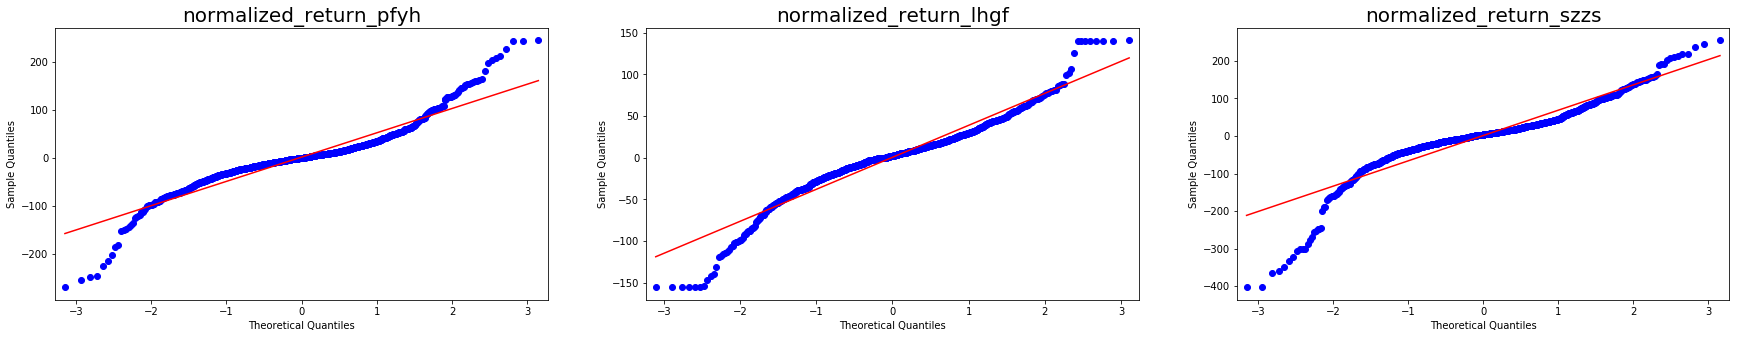

In [46]:
Q9_1(rts1,name1,rts2,name2,rts3,name3)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.33088561748064876
            Iterations: 27
            Function evaluations: 180
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2424458586509982
            Iterations: 40
            Function evaluations: 264
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.38439939954021163
            Iterations: 47
            Function evaluations: 320
            Gradient evaluations: 47


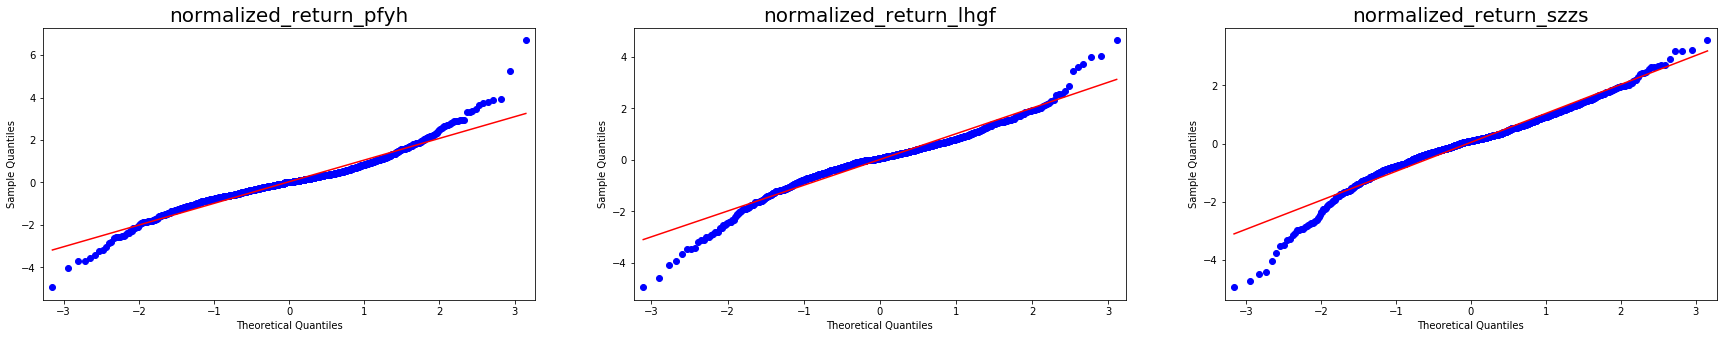

In [47]:
Q9_2_3(rts1,name1,rts2,name2,rts3,name3)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.33088561748064876
            Iterations: 27
            Function evaluations: 180
            Gradient evaluations: 27
Initial Values= [  7.00000000e-02   8.50000000e-01   5.00000000e-01   5.00000000e-06]
Estimated Values= [  1.70764761e-01   8.23517608e-01  -1.82985297e-01   5.46109237e-06]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2424458586509982
            Iterations: 40
            Function evaluations: 264
            Gradient evaluations: 40
Initial Values= [  7.00000000e-02   8.50000000e-01   5.00000000e-01   5.00000000e-06]
Estimated Values= [  7.07788826e-02   8.79924759e-01  -1.72532993e-01   3.06959947e-05]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.38439939954021163
            Iterations: 47
            Function evaluations: 320
            Gradient evaluations: 47
Initial Val

NameError: name 'z' is not defined

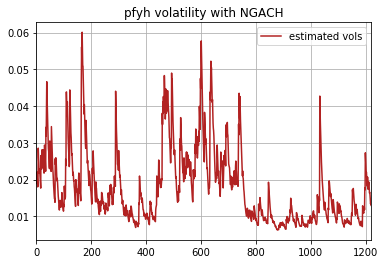

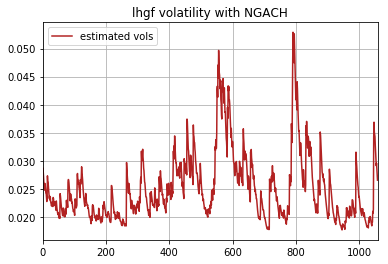

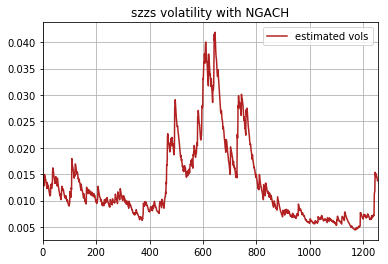

In [48]:
Q9_4(rts1,name1,rts2,name2,rts3,name3)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.33088561748064876
            Iterations: 27
            Function evaluations: 180
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.33088561748064876
            Iterations: 27
            Function evaluations: 180
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.33088561748064876
            Iterations: 27
            Function evaluations: 180
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2424458586509982
            Iterations: 40
            Function evaluations: 264
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2424458586509982
            Iterations: 40
       

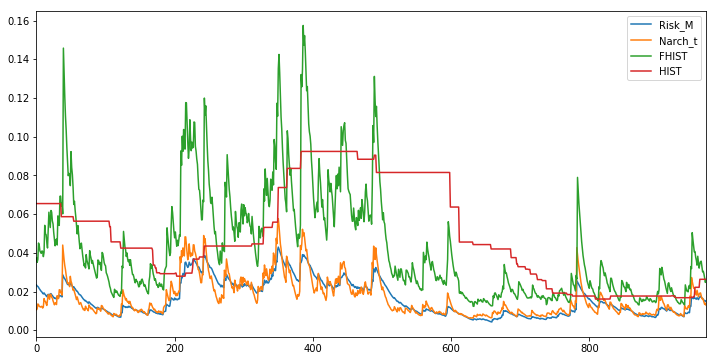

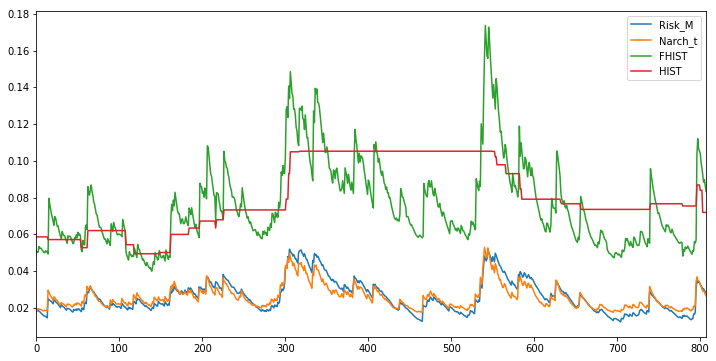

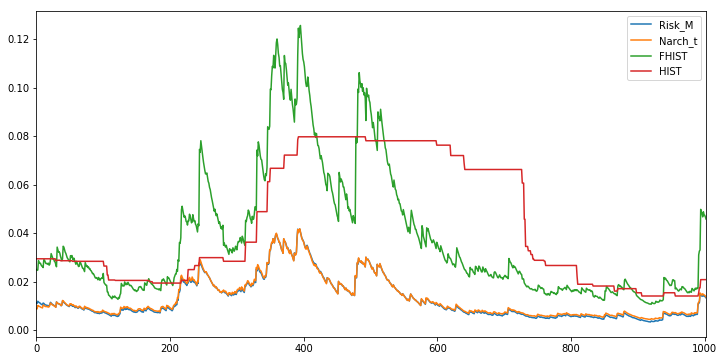

In [49]:
Q9_7(rts1,name1,rts2,name2,rts3,name3)

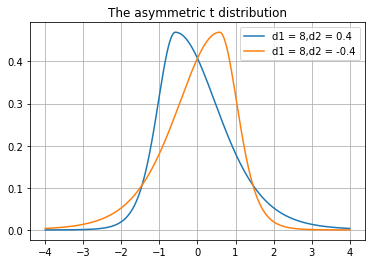

In [50]:
Q_9_8()

In [51]:
def Asymmetric_t_dist(d1,d2,out = None):
    C = gamma((d1+1)*0.5) / (gamma(d1/2)*np.sqrt(np.pi*(d1-2)))
    A = 4*d2*C*(d1-2)/(d1-1)
    B = np.sqrt(1+3*d2**2-A**2)
    m2 = 1+ 3*d2**2
    m3 = 16*C*d2*(1+d2**2)*(d1-2)**2 / ((d1-1)*(d1-3))
    m4 = 3*(d1-2)*(1+10*d2**2+5*d2**4)/(d1-4)
    skew = (m3-3*m2*A +2*A**3)/B**3
    excess_kur = ((m4-4*A*m3+6*A**2*m2-3*A**4)/B**4) - 3
    pdf=[
    B*C*(1+(B*x+A)**2/((1-d2)**2*(d1-2)))**(-0.5*(1+d1)) if x < -(A/B) else B*C*(1+(B*x+A)**2/((1+d2)**2*(d1-2)))**(-0.5*(1+d1)) for x in  np.linspace(-4,4,1000)
]
    if out == None:
        return pdf
    if out == "skew":
        return skew
    if out =="e_kur":
        return excess_kur

In [52]:
a = [ Asymmetric_t_dist(d1=5, d2 = x, out="skew") for x in np.linspace(-0.9,0.9,20)]

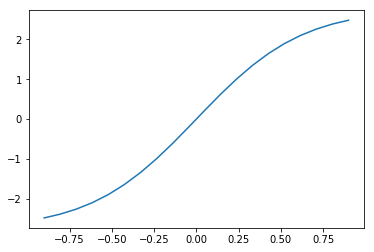

In [53]:
plt.plot(np.linspace(-0.9,0.9,20),a)

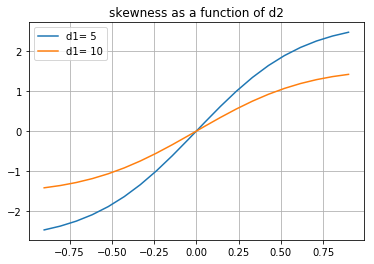

In [54]:
Q9_9_1()

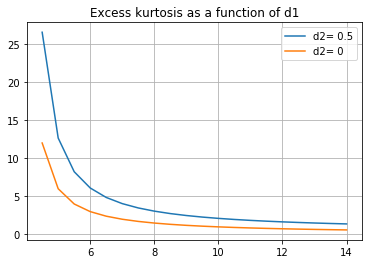

In [55]:
Q9_9_2()

In [56]:
pfyh_vol = pd.Series(Ngarch_hv(rts1,name1,p=2),index = rts1.index)
lhgf_vol = pd.Series(Ngarch_hv(rts2,name2,p=2),index = rts2.index)
szzs_vol = pd.Series(Ngarch_hv(rts3,name3,p=2),index = rts3.index)

df = pd.concat([pfyh_vol,lhgf_vol,szzs_vol],axis = 1)

df.columns = ["pfyh_vol","lhgf_vol","szzs_vol"]

standardized_rertun1 = rts1/pfyh_vol
standardized_rertun2 = rts2/lhgf_vol
standardized_rertun3 = rts3/szzs_vol

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.33088561748064876
            Iterations: 27
            Function evaluations: 180
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2424458586509982
            Iterations: 40
            Function evaluations: 264
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.38439939954021163
            Iterations: 47
            Function evaluations: 320
            Gradient evaluations: 47


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 922.5763217273955
            Iterations: 7
            Function evaluations: 28
            Gradient evaluations: 7


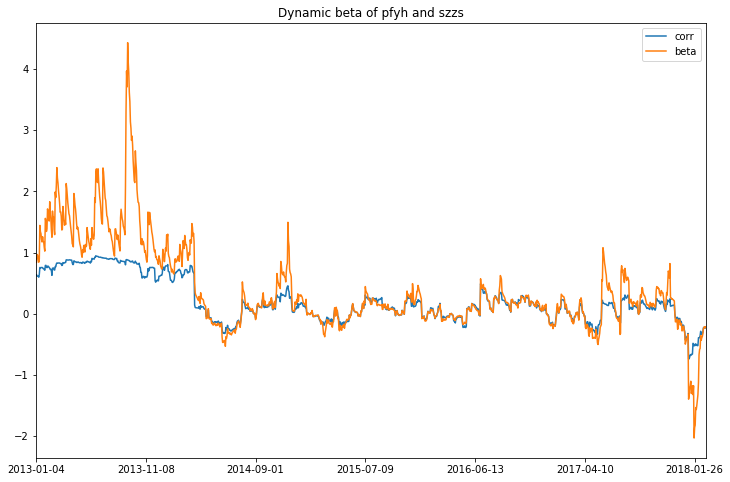

In [57]:
Q10(standardized_rertun1,pfyh_vol,name1,standardized_rertun3,szzs_vol,name3)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 923.0989869781496
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5


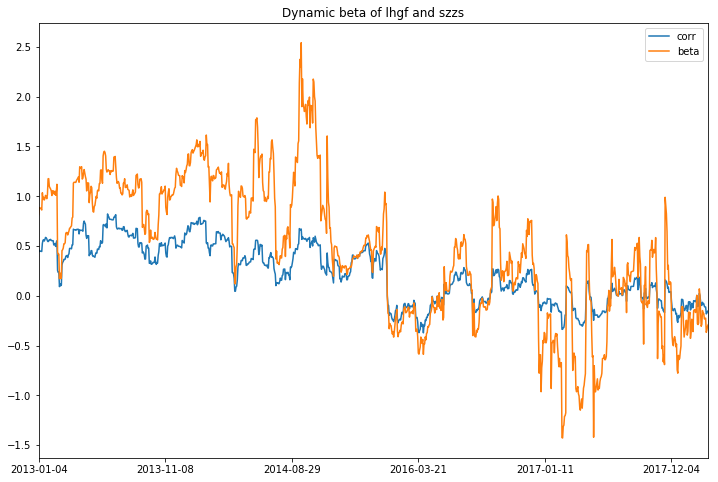

In [58]:
Q10(standardized_rertun2,lhgf_vol,name2,standardized_rertun3,szzs_vol,name3)

In [666]:
startingVals = np.array([0.05,0.9])
args = (standardized_rertun2,standardized_rertun3)
bounds = [(0.0,1.0),(0.0,1.0)]
estimats = fmin_slsqp(GARCH_DCC_loglikelihood,startingVals,args = args,bounds = bounds,f_ieqcons=GARCH_DCC_constraint)

C:\Users\cx\Anaconda3\lib\site-packages\ipykernel_launcher.py:399: RuntimeWarning: divide by zero encountered in log
C:\Users\cx\Anaconda3\lib\site-packages\ipykernel_launcher.py:399: RuntimeWarning: invalid value encountered in log


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1742.2819667728024
            Iterations: 18
            Function evaluations: 78
            Gradient evaluations: 15


In [667]:
estimats

array([ 0.00784733,  0.9898999 ])

In [789]:
_,estimats = Ngarch_hv(rts3,name1,p=0)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.38407137566135924
            Iterations: 51
            Function evaluations: 346
            Gradient evaluations: 51


In [804]:
df = pd.read_excel("222.xlsx")

In [746]:
startingVals = np.array([0.07,0.85,0.5,0.000005]) 
bounds =[(0.0,1.0),(0.0,1.0),(-10.0,10.0),(0.0,1.0)] 
args = (np.asarray(df.Rt),)
estimats = fmin_slsqp(Ngarch_loglikelihood,startingVals,bounds = bounds,args = args)

C:\Users\cx\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7.915172410660831
            Iterations: 16
            Function evaluations: 129
            Gradient evaluations: 16


In [747]:
estimats

array([  5.51862493e-02,   8.36665342e-01,   1.34539386e+00,
         1.71064176e-06])

In [808]:
Ngarch_hv(rts3,name1,p =0)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.38407137566135924
            Iterations: 51
            Function evaluations: 346
            Gradient evaluations: 51


(array([ 0.01482699,  0.0144004 ,  0.01399348, ...,  0.01460719,
         0.01438846,  0.0141216 ]),
 array([  6.41711717e-02,   9.35226339e-01,  -6.31634969e-02,
          5.32573701e-07]))

In [822]:
startingVals = np.array([0.05,0.9])
args = (standardized_rertun1,standardized_rertun3)
bounds = [(0.0,1.0),(0.0,1.0)]
estimats = fmin_slsqp(GARCH_DCC_loglikelihood,startingVals,args = args,bounds = bounds,f_ieqcons=GARCH_DCC_constraint)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 939.6093301927561
            Iterations: 17
            Function evaluations: 82
            Gradient evaluations: 17


In [846]:
alpha = estimats[0]
beta = estimats[1]

In [847]:
np.random.seed(0)
shock1= np.random.randn(1000)
shock2 = np.random.randn(1000)

In [848]:
q11= shock1**2*alpha + beta + (1-alpha-beta)
q22= shock2**2*alpha + beta + (1-alpha-beta)

In [849]:
df = pd.concat([standardized_rertun1,standardized_rertun3],axis =1)
unconditional_corr = df.corr().iloc[0,1]

In [850]:
x =0.5
q12 = (1-alpha-beta)*unconditional_corr + beta*x + alpha*shock1*shock2

In [852]:
rol12 = q12/np.sqrt(q11*q22)

In [854]:
np.average(rol12)

0.50139882500974109

In [918]:
x =0.3
shock1 = np.random.randn(100)
shock2 = np.random.randn(100)
startingVals = np.array([0.05,0.9])
args = (standardized_rertun1,standardized_rertun3)
bounds = [(0.0,1.0),(0.0,1.0)]
estimats = fmin_slsqp(GARCH_DCC_loglikelihood,startingVals,args = args,bounds = bounds,f_ieqcons=GARCH_DCC_constraint)
alpha = estimats[0]
beta = estimats[1]
df = pd.concat([standardized_rertun1,standardized_rertun3],axis =1)
unconditional_corr = df.corr().iloc[0,1]
q11 = shock1**2*alpha + beta + (1-alpha-beta)
q22 = shock2**2*alpha + beta + (1-alpha-beta)
q12 = (1-alpha-beta)*unconditional_corr + beta*x + alpha*shock1*shock2
rol_0 = np.average(q12/np.sqrt(q11*q22))
rol = []
rol.append(rol_0)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 939.6093301927561
            Iterations: 17
            Function evaluations: 82
            Gradient evaluations: 17


In [919]:
for i in range(100):
    np.random.seed(i)
    shock1 = np.random.randn(100)
    shock2 = np.random.randn(100)
    q11 = shock1**2*alpha + beta*q11 + (1-alpha-beta)
    q22 = shock2**2*alpha + beta*q22 + (1-alpha-beta)
    q12 = (1-alpha-beta)*unconditional_corr + beta*q12 + alpha*shock1*shock2
    rol12 = q12/np.sqrt(q11*q22)
    rol.append(np.average(rol12))
    i +=1

In [925]:
startingVals = np.array([0.05,0.9])
args = (rts1,rts2)
bounds = [(0.0,1.0),(0.0,1.0)]
estimats = fmin_slsqp(GARCH_DCC_loglikelihood,startingVals,args = args,bounds = bounds,f_ieqcons=GARCH_DCC_constraint)

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -27.512032536915147
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4


In [975]:
def DCC_Monte(rts1,rts2,estimats,x):
    shock1 = np.random.randn(10000)
    shock2 = np.random.randn(10000)
    alpha = estimats[0]
    beta = estimats[1]
    df = pd.concat([rts1,rts2],axis =1)
    unconditional_corr = df.corr().iloc[0,1]
    q11 = shock1**2*alpha + beta + (1-alpha-beta)
    q22 = shock2**2*alpha + beta + (1-alpha-beta)
    q12 = (1-alpha-beta)*unconditional_corr + beta*x + alpha*shock1*shock2
    rol_0 = np.average(q12/np.sqrt(q11*q22))
    rol = []
    rol.append(rol_0)
    for i in range(20):
        np.random.seed(i)
        shock1 = np.random.randn(10000)
        shock2 = np.random.randn(10000)
        q11 = shock1**2*alpha + beta*q11 + (1-alpha-beta)
        q22 = shock2**2*alpha + beta*q22 + (1-alpha-beta)
        q12 = (1-alpha-beta)*unconditional_corr + beta*q12 + alpha*shock1*shock2
        rol12 = q12/np.sqrt(q11*q22)
        rol.append(np.average(rol12))
        i +=1
    return pd.Series(rol,name=str(x))

In [976]:
def Q11():
    data={
        "0.5":DCC_Monte(standardized_rertun1,standardized_rertun3,estimats,x = 0.5),
        "0.3":DCC_Monte(standardized_rertun1,standardized_rertun3,estimats,x = 0.3),
        "- 0.1":DCC_Monte(standardized_rertun1,standardized_rertun3,estimats,x = - 0.1),              
        "- 0.4":DCC_Monte(standardized_rertun1,standardized_rertun3,estimats,x =- 0.4)                          
                        }
    df = pd.DataFrame(data)
    df.plot()

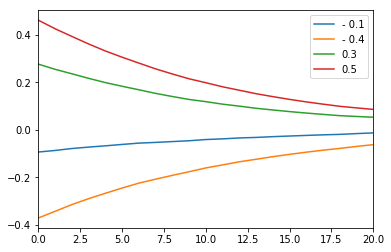

In [977]:
Q11()

In [907]:
x = np.array([1,2])
x = x +2

In [950]:
pd.DataFrame([1,2],[3,4])

,0
3,1
4,2


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -33.019139909572665
            Iterations: 11
            Function evaluations: 50
            Gradient evaluations: 11
Initial Values= [ 0.1   0.85]
Estimated Values= [ 0.14663673  0.84005315]


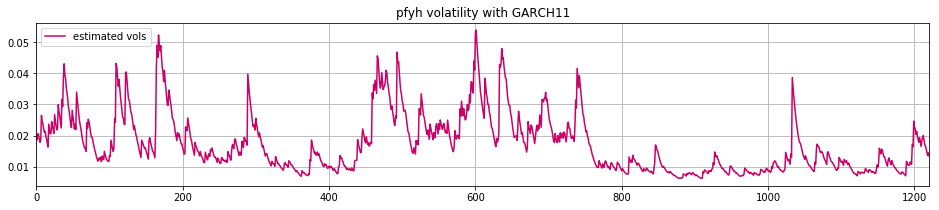

In [38]:
garch_hv(rts1,name1)

In [1]:
def Q12(df,rts,name):
    vol,para = Ngarch_hv(rts,name,p = 3)
    r = np.zeros((31,100000)) 
    v = np.zeros((31,100000)) 
    S = np.zeros((31,100000))
    r[0,:] = rts2[-1]
    v[0,:] = vol[-1]
    S[0,:] = df.close[-1]
    for i in range(30):
        shock = np.random.randn(100000)
        v[1+i,:] = np.sqrt(para[3] + para[0] * (r[0+i,:] - para[2]*v[0+i,:])**2  + para[1]*(v[0+i,:])**2)
        r[1+i,:] = shock * v[1+i,:]
        S[1+i,:] = np.exp(np.log(S[0+i,:]) + r[1+i,:])
    St = S[-1,:]
    K = df1.close[-1] + 1
    C = St-K
    C[C<0] = 0
    c  = C.mean()/np.power((1 + 0.03/360),30)
    print(name + ' 的欧式期权价格为：  ',c)

def Q13_1_2():
    df = pd.read_excel('Chapter2_Data.xls',parse_dates=[0],sheetname='Question 2.1 & 2.2 (Short)')
    df.index=df.pop('Date')
    new_df = pd.DataFrame(df.Close)
    rts = 100 * np.log(new_df/new_df.shift(1)).dropna()
    minus_rts = -1 * rts

    new_df['VaR Short'] = 0
    for i in range(len(minus_rts)-252):
        new_df['VaR Short'][252+i:] = np.percentile(minus_rts[2+i:252+i],1)
    new_df['WHS Short'] = 0
    for i in range(len(rts)-252):
        rts1 = sorted(rts.Close[-249-(len(rts)-252)+i : -(len(rts)-252)+i])
        new_df['WHS Short'][252+i:] = rts1.pop()
    new_df['VaR Long'] = 0
    for i in range(len(minus_rts)-252):
        new_df['VaR Long'][252+i:] = np.percentile(minus_rts[2+i:252+i],99)
    new_df['WHS Long'] = 0
    for i in range(len(rts)-252):
        rts1 = sorted(rts.Close[-249-(len(rts)-252)+i : -(len(rts)-252)+i])
        new_df['WHS Long'][252+i:] = -1 * rts1.pop(0)


    plt.figure(figsize=(15,5))
    plt.subplot(221)
    plt.grid()
    plt.plot(minus_rts[250:],color = '#4682B4',linewidth = 3,label = 'return')
    plt.plot(new_df['VaR Short'][252:],color = '#006400',linewidth = 3,label = 'VaR Short (HS)')
    plt.legend(loc='upper left')

    plt.subplot(222)
    plt.grid()
    plt.plot(minus_rts[250:],color = '#4682B4',linewidth = 3,label = 'return')
    plt.plot(new_df['WHS Short'][252:],color = '#006400',linewidth = 3,label = 'VaR Short (WHS)')
    plt.legend(loc='upper left')

    plt.subplot(223)
    plt.grid()
    plt.plot(minus_rts[250:],color = '#4682B4',linewidth = 3,label = 'return')
    plt.plot(new_df['VaR Long'][252:],color = '#006400',linewidth = 3,label = 'VaR Long (HS)')
    plt.legend(loc='upper left')

    plt.subplot(224)
    plt.grid()
    plt.plot(minus_rts[250:],color = '#4682B4',linewidth = 3,label = 'return')
    plt.plot(new_df['WHS Long'][252:],color = '#006400',linewidth = 3,label = 'VaR Long (WHS)')
    plt.legend(loc='upper left')

def Q13_3_4():    
    df = pd.read_excel('Chapter2_Data.xls',parse_dates=[0],sheetname='Question 2.3 & 2.4')
    df.index=df.pop('Date')
    new_df = pd.DataFrame(df['S&P500'])
    rts = np.log(new_df/new_df.shift(1)).dropna()
    lam = 0.94
    RiskM = [0] * (len(rts) + 2)
    RiskM10 = [0] * (len(rts) + 2)
    for i in range(len(rts)-1):
        RiskM[3+i] = (1 - lam) * (rts['S&P500'][0+i])**2 + lam * RiskM[2+i]
        RiskM10[3+i] = -1 * np.sqrt(10) * norm.ppf(0.01) * np.sqrt(RiskM[3+i])
    HS10 = [0] * (len(rts) + 2)
    for i in range(len(rts) - 250):
        HS10[252+i] = -1 * np.sqrt(10) * np.percentile(rts[0+i:250+i],1)
    new_df['RiskM-10'] = RiskM10
    new_df['HS-10'] = HS10
    
    new_df['PRM'] = 0
    new_df['PHS'] = 0
    new_df['PLRM'] = 0
    new_df['PLHS'] = 0
    new_df['CPLRM'] = 0
    new_df['CPLHS'] = 0
    data = new_df['2008-06-30':'2009-12-31']
    data['PRM'] = 100000 / data['RiskM-10']
    data['PHS'] = 100000 / data['HS-10']
    for i in range(len(data['PHS']) - 1):
        data['PLRM'][i+1] = (data['S&P500'][i+1] / data['S&P500'][i] - 1) * data['PRM'][i+1]
        data['PLHS'][i+1] = (data['S&P500'][i+1] / data['S&P500'][i] - 1) * data['PHS'][i+1]
        data['CPLRM'][i+1] = data['CPLRM'][0+i] + data['PLRM'][1+i]
        data['CPLHS'][i+1] = data['CPLHS'][0+i] + data['PLHS'][1+i]
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.grid()
    plt.plot(new_df['RiskM-10']['2008-07-01':'2009-12-31'],color = '#4682B4',linewidth = 3,label = 'RiskMetrics 10days')
    plt.plot(new_df['HS-10']['2008-07-01':'2009-12-31'],color = '#006400',linewidth = 3,label = 'HS 10days')
    plt.legend(loc='upper left')

    plt.subplot(122)
    plt.grid()
    plt.plot(data['CPLRM']['2008-07-01':'2009-12-31'],color = '#4682B4',linewidth = 3,label = 'P/L from Risk Metrics VaR')
    plt.plot(data['CPLHS']['2008-07-01':'2009-12-31'],color = '#006400',linewidth = 3,label = 'P/L from HS VaR')
    plt.legend(loc='upper left')

def shu(df,DV,dv):
    df['d'] = (np.log(df['S (Index)']/df['X (Strike)']) + (df['r'] - df['q'] + (DV**2)/2) * df['T (DTM)']) / (DV * np.sqrt(df['T (DTM)']))
    df['F(d)'] = norm.cdf(df['d'])
    df['f(d)'] = norm.pdf(df['d'])
    df['Position'] = -1
    df['Delta'] = df['Position'] * np.exp(-1 * df['q'] * df['T (DTM)']) * df['F(d)']
    df['Gamma'] = df['Position'] * df['f(d)'] * np.exp(-1 * df['q'] * df['T (DTM)']) / (df['S (Index)'] * DV * np.sqrt(df['T (DTM)']))   
    df['Delta-Based Portfolio Variance'] = df['Delta']**2 * df['S (Index)']**2 * dv**2
    df['10-day 1% $VaR'] = -1 * np.sqrt(df['Delta-Based Portfolio Variance']) * np.sqrt(10) * norm.ppf(0.01)
def Q14_1():    
    df = pd.read_excel('Chapter11_Data.xls',parse_dates=[0],sheetname='Question 11.1')
    shu(df,DV,dv)
    VaR = np.array(df['10-day 1% $VaR'])
    print('10-day 1% $VaR is :')
    print(VaR)
def Q14_2():
    df = pd.read_excel('Chapter11_Data.xls',parse_dates=[0],sheetname='Question 11.2')
    shu(df,DV,dv)
    Delta = np.sum(df['Delta'])
    Gamma = np.sum(df['Gamma'])
    Delta_Based = [0] * len(df['Simulated    10-day returns']) 
    Gamma_Based = [0] * len(df['Simulated    10-day returns'])
    for i in range(len(df['Simulated    10-day returns'])):
        df['Simulated    10-day returns'][0+i] = random.normalvariate(0,1) * dv* np.sqrt(HOR)    
        Delta_Based[0+i] = Delta * df['S (Index)'][1] * df['Simulated    10-day returns'][0+i]
        Gamma_Based[0+i] = Delta_Based[0+i] + 0.5 * Gamma * (df['S (Index)'][1])**2 * (df['Simulated    10-day returns'][0+i])**2
    mDV = 0.5* Gamma * (df['S (Index)'][1])**2 * (dv)**2 * HOR
    s2DV = Delta**2 * (df['S (Index)'][1])**2 * (dv)**2 * HOR + 0.5*Gamma**2 * ((df['S (Index)'][1])**2)**2 * (dv**2)**2 *(HOR**2)**2
    zDV = (4.5*(Delta)**2*Gamma*np.power(df['S (Index)'][1],4)*np.power(dv,4)*np.power(HOR,4) + 1.875*np.power(Gamma,3)*np.power(df['S (Index)'][1],6)*np.power(dv,6)*np.power(HOR,3) - 3*mDV*(Delta**2*(df['S (Index)'][1])**2*dv**2*HOR+0.75* Gamma**2* np.power(df['S (Index)'][1],4)*np.power(dv,4)*HOR**2)+2*np.power(mDV,3) )/ np.power(mDV,1.5)
    DVaR = -np.percentile(Delta_Based,0.01)
    GVaR = -np.percentile(Gamma_Based,0.01)
    Cornish_Fisher = -mDV-np.sqrt(s2DV)*(norm.ppf(0.01)+(norm.ppf(0.01)**2-1)*(mDV/6))
    print('Delta VaR  :  ' , DVaR)
    print('\nGamma VaR   :  ', GVaR)
    print('\nCornish_Fisher :  ',Cornish_Fisher)
def Q14_3(): 
    T=43
    X=1135	
    C=26.54	
    St=1137.14	
    r=0.000682/100
    q=0.005697/100	
    d=(np.log(St/X)+(r-q+0.5*(DV)**2)*T)/(DV*np.sqrt(T))
    delta = -1*np.exp(-T*q)*norm.cdf(d)
    gamma =-1*norm.pdf(d)*np.exp(-T*q)/(St*DV*np.sqrt(T))
    Rh = [0]*5000
    Sh = [0]*5000
    BSTt = [0]*5000
    BSD = [0]*5000
    BSds = [0]*5000
    BSc = [0]*5000
    db = [0]*5000
    gb = [0]*5000
    fv = [0]*5000
    for i in range(5000):
        Rh[i] = random.normalvariate(0,1)*dv*np.sqrt(HOR)
        Sh[i] = St * np.exp(Rh[i])
        BSTt[i] = T - 14
        BSD[i] = (np.log(Sh[i]/X)+(r-q+(DV**2)/2)*BSTt[i])/(DV*np.sqrt(BSTt[i]))
        BSds[i] = BSD[i]-DV*np.sqrt(BSTt[i])
        BSc[i] = Sh[i]*np.exp(-q*BSTt[i])*norm.cdf(BSD[i])-X*np.exp(-r*BSTt[i])*norm.cdf(BSds[i])
        db[i] = delta*St*Rh[i]
        gb[i] = db[i]+0.5*gamma*St**2*Rh[i]**2
        fv[i] = C-BSc[i]
    DVaR = -np.percentile(db,0.01)
    GVaR = -np.percentile(gb,0.01)
    fvVaR = -np.percentile(fv,0.01)
    print('Delta VaR  :  ' , DVaR)
    print('\nGamma VaR   :  ', GVaR)
    print('\nFull Valuation  :  ',fvVaR)
    drawhist(db,'Delta-Based',gb,'Gamma-Based',fv,'Full Valuation')
def Q14_4():
    df = pd.read_excel('Chapter11_Data.xls',parse_dates=[0],sheetname='Question 11.4')
    T = np.array(df['T (DTM)'][1:])
    S = np.array(df['S'][1:])
    r = np.array(df['r'][1:])
    dx95 = [0]*len(T)
    dx105 = [0]*len(T)
    fv = [0]*len(T)
    fv1 = [0]*len(T)
    fv2 = [0]*len(T)
    fv3 = [0]*len(T)
    db = [0]*len(T)
    gb = [0]*len(T)	
    c95 = -1.5
    sp1 = 95
    c105 = 2.5
    sp2 = 105
    p = -1
    for i in range(len(T)):
        dx95[i] = (np.log(S[i]/sp1)+(r[i]+0.5*DV**2)*T[i])/(DV*np.sqrt(T[i]))
        dx105[i] = (np.log(S[i]/sp2)+(r[i]+0.5*DV**2)*T[i])/(DV*np.sqrt(T[i]))
        fv1[i] = round(c95*(S[i]*norm.cdf(dx95[i])-sp1*np.exp(-r[i]*T[i])*norm.cdf(dx95[i]-DV*np.sqrt(T[i]))),2)
        fv2[i] = round(c105*(S[i]*norm.cdf(dx105[i])-sp2*np.exp(-r[i]*T[i])*norm.cdf(dx105[i]-DV*np.sqrt(T[i]))),2)
        fv3[i] = round(p*(-S[i]*norm.cdf(-dx95[i])+sp1*np.exp(-r[i]*T[i])*norm.cdf(-(dx95[i]-DV*np.sqrt(T[i])))),2)
        fv[i] = fv1[i]+fv2[i]+fv3[i]
    VPF = fv.pop(0)
    d = c95*norm.cdf(dx95[0])+c105*norm.cdf(dx105[0])+p*(norm.cdf(dx95[0])-1)
    g = c95*norm.pdf(dx95[0])/(S[0]*DV*np.sqrt(T[0]))+c105*norm.pdf(dx105[0])/(S[0]*DV*np.sqrt(T[0]))+p*norm.pdf(dx95[0])/(S[0]*DV*np.sqrt(T[0]))
    for i in range(len(T)):
        db[i] = VPF+d*(S[i]-S[0])
        gb[i] = VPF+d*(S[i]-S[0])+0.5*g*((S[i]-S[0])**2)
    del(db[0])
    del(gb[0])
    plt.figure(figsize=(15,5))
    plt.grid()
    plt.plot(fv,linewidth = 3,label = 'Full Valuation')
    plt.plot(db,linewidth = 3,label = 'Delta-based')
    plt.plot(gb,linewidth = 3,label = 'Gamma-based')
    plt.legend(loc='upper left')